### Bonus: A Shallow Dive into Deep Learning

To put what I've learned in the Deep Learning Unit into practice, I will attempt to improve upon my Gradient Boosting model from the Machine Learning notebook.

In [1]:
# Import pandas for reading in the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

The initial setup is the same as before.

In [2]:
top_stocks = pd.read_hdf('../data/clean/computed_stocks.h5', key='stocks_current')

top_stocks.reset_index(inplace=True)
top_stocks.drop_duplicates(['symbol', 'date'], inplace=True)
top_stocks.set_index('date', inplace=True)

In [3]:
top_stocks.index = pd.to_datetime(top_stocks.index)

In [4]:
top_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528064 entries, 2015-06-17 00:00:00-04:00 to 2020-05-12 00:00:00-04:00
Data columns (total 72 columns):
symbol                                   528064 non-null object
close                                    528064 non-null float64
bb_upper_5                               528064 non-null float64
linear_regression_angle_20               528064 non-null float64
bb_width_20                              528064 non-null float64
mom_5                                    528064 non-null float64
natr_5                                   528064 non-null float64
tema_20                                  528064 non-null float64
tsf_20                                   528064 non-null float64
bb_middle_20                             528064 non-null float64
linear_regression_slope_5                528064 non-null float64
linear_regression_angle_5                528064 non-null float64
natr_20                                  528064 non-null float64

In [5]:
import json
COLUMNS = []

with open('../models/columns.json') as column_file:
    COLUMNS = json.load(column_file)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler

X = top_stocks[COLUMNS]
y = top_stocks[['buy_signal']]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Using Theano backend.


In [7]:
sm = RandomUnderSampler()
X_train, y_train = sm.fit_resample(X_train, y_train)

To create the neural network model, I will use the Keras library, which is built upon TensorFlow. Keras requires that the result column is in a categorical format, but it provides the function "to_categorical" for this purpose.

The data must first be scaled to improve accuracy. The test data is not scaled independently, but according to the fit of the train data. After testing both the StandardScaler and the MinMaxScaler, the StandardScaler performs better and converges in fewer epochs.

In [8]:
from pickle import dump
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dump(scaler, open('../models/scaler.pkl', 'wb'))

In [9]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train) 
y_test_cat = to_categorical(y_test)

To build the neural network, I used a simple sequential model with just one hidden layer containing 100 nodes. I tested many different configurations, but adding layers and nodes did not improve the final test accuracy score. The Rectified Linear Unit or "RELU" activation function performs better than sigmoid activation functions like "tanh". The output layer must have 2 nodes, representing a win or a loss. The "softmax" activation function is also necessary for binary classification, as it converts the outputs to probabilities and ensures that they add up to 1.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()

model.add(Dense(200, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

The model was compiled with the "adam" optimizer. I also chose the "categorical_crossentropy" loss function, a good default for classification. 

In [11]:
from keras.metrics import accuracy
from keras.optimizers import Adam

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

When fitting the model, I used two callbacks provided by Keras. The EarlyStopping callback stops when the validation loss function does not improve after five epochs. The ModelCheckpoint callback saves the model with the best validation accuracy score. I experimented with splitting the training data to create an additional validation set, but setting the test data as the validation set optimizes for test set accuracy.

In [12]:
from keras.callbacks.callbacks import EarlyStopping
from keras.callbacks.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3)
mc = ModelCheckpoint('../models/daily.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_scaled, y_train_cat, 
          epochs=20, 
          callbacks= [es, mc], 
          batch_size=64,
          validation_data=(X_test_scaled, y_test_cat), 
          shuffle=True)

Train on 417380 samples, validate on 105613 samples
Epoch 1/20
417380/417380 [==============================] - 12s 28us/step - loss: 0.6684 - accuracy: 0.5730 - val_loss: 0.6398 - val_accuracy: 0.6137
Epoch 2/20
417380/417380 [==============================] - 12s 29us/step - loss: 0.6261 - accuracy: 0.6336 - val_loss: 0.6191 - val_accuracy: 0.6456
Epoch 3/20
417380/417380 [==============================] - 12s 29us/step - loss: 0.6089 - accuracy: 0.6544 - val_loss: 0.6128 - val_accuracy: 0.6521
Epoch 4/20
417380/417380 [==============================] - 12s 29us/step - loss: 0.6001 - accuracy: 0.6636 - val_loss: 0.5995 - val_accuracy: 0.6646
Epoch 5/20
417380/417380 [==============================] - 12s 29us/step - loss: 0.5941 - accuracy: 0.6695 - val_loss: 0.6006 - val_accuracy: 0.6634
Epoch 6/20
417380/417380 [==============================] - 12s 29us/step - loss: 0.5899 - accuracy: 0.6742 - val_loss: 0.5931 - val_accuracy: 0.6708
Epoch 7/20
417380/417380 [======================

An evaluation of the best model shows a test accuracy of 66.5%. This outperforms any of my previous Machine Learning models, even after hyperparameter tuning. 

In [13]:
from keras.models import load_model

best_model = load_model('../models/daily.h5')
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train_cat)
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test_cat)
print(train_loss, test_loss)
print(train_accuracy, test_accuracy)

105613/105613 [==============================] - 1s 9us/step
0.5724815985651385 0.5853612834943369
0.6899060606956482 0.6791398525238037


In [14]:
predictions = pd.DataFrame(zip(best_model.predict(X_test_scaled)[:, 1], y_test_cat[:, 1]),
                           columns=['prediction', 'signal'])

In [15]:
predictions['prediction_correct'] = ((predictions.prediction >= 0.5) & (predictions.signal == 1)) | \
                                    ((predictions.prediction < 0.5) & (predictions.signal == 0))

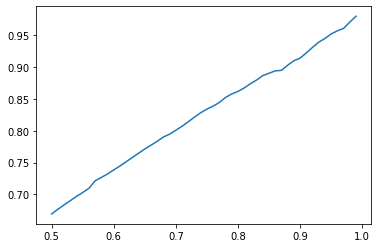

In [16]:
def buy_signal_curve():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.prediction_correct == True)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(correct / total)
    plt.plot(odds, curve)
    
buy_signal_curve()

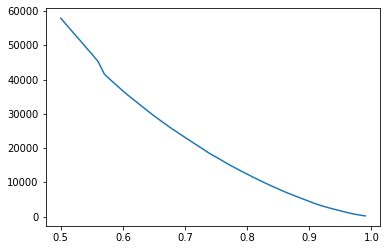

In [17]:
def buy_signal_curve_2():
    curve = []
    odds = np.arange(.5, 1.0, .01)
    for o in odds:
        total = len(predictions[predictions.prediction > o])
        correct = len(predictions[(predictions.prediction > o) & (predictions.signal == 1)])
        if total == 0:
            curve.append(1)
        else:
            curve.append(total)
    plt.plot(odds, curve)
    
buy_signal_curve_2()

I do not believe that the model has much room for improvement. For proof, I trained the model for 100 epochs, and plotted its history. As shown below, the test loss steadily increases after only a few epochs. Similarly, the test accuracy decreases after only a few epochs, then converges. Even at a training accuracy of 75%, the model is overfitting.

The presence of upsets in the match data throw off any attempt at finding general patterns in the features. Increasing the training accuracy can only reduce the model's ability to generalize for the test data. To improve the model at this point, I would need to add new features that can generalize more effectively when encountering upsets in the training data.

. | .
- | - 
![loss](epoch-loss.png) | ![loss](epoch-accuracy.png) 

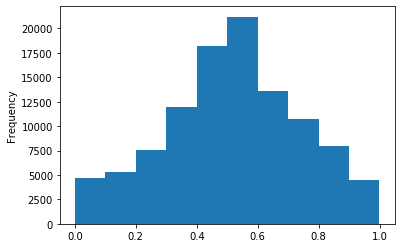

In [18]:
predictions.prediction.plot(kind='hist')

In [19]:
symbols = top_stocks.symbol.unique()

In [20]:
def backtest(forecasts, predictions, buy):
    baseline = 100
    model = 100
    position = 100
    trade = 100
    buy_signal = False
    for date, prediction in zip(forecasts.index, predictions):
        if prediction > buy:
            if buy_signal == False:
                trade = 100
                position = trade
                model -= position
                buy_signal = True
        elif prediction <= buy:
            if buy_signal == True:
                model += position
                buy_signal = False
        if buy_signal == True:
            position += position * forecasts[date]
        baseline += baseline * forecasts[date]
    if buy_signal == True:
        model += position
    return baseline, model

In [21]:
from tqdm.notebook import tqdm

def calculate_profit(symbol, buy):
    X = top_stocks[top_stocks.symbol == symbol][COLUMNS]
    if X.shape[0] == 0:
        return 0, 0
    X_scaled = scaler.transform(X)
    predictions = best_model.predict(X_scaled)[:, 1]
    forecasts = top_stocks[top_stocks.symbol == symbol].forecast
    
    return backtest(forecasts, predictions, buy)

baselines = []
models = []

num_symbols = 50

for symbol in tqdm(symbols[:num_symbols]):
    baseline, model = calculate_profit(symbol, .5)
    print(symbol, baseline, model)
    if baseline == 0:
        num_symbols -= 1
    baselines.append(baseline)
    models.append(model)

num_symbols * 100, sum(baselines), sum(models)

A 202.4242424242425 638.0608613544043
AA 19.453734671125968 829.8860813308178
AAL 22.843530591775345 744.4623515993305
AAPL 241.67321288295375 596.1894079430832
AAXN 363.2532850022657 516.5235687623831
ABB 80.16157989228006 510.79342923662824
ABBV 131.1347203777482 520.8341744804277
ABC 75.46408393866014 487.45346643799667
ABEV 31.803278688524557 477.64154656341407
ABT 189.74675725756634 558.2026298165486
ACB 5.486189935679151 163.3934903539078
ACN 186.732693696482 600.0801990506984
ADBE 460.22333461686543 752.1778579560196
ADI 154.395359214636 720.0991681221811
ADM 66.43109540636026 504.0709243570764
ADP 161.60912638847196 564.4900864966007
ADSK 330.1166588894073 836.4681080617664
ADT 15.407690209980904 397.5947722939118
AEO 44.09038238702204 605.8215158732771
AES 84.93050475493796 552.1101276451409
AFL 102.41716023691372 503.59477523357
AGNC 58.82647943831497 318.35705286306404
AIG 40.349175557710886 576.9563705849084
AKAM 130.98475484136765 576.1687614498244
ALL 137.06460256028566 4

(5000, 9038.906111275573, 30088.938323456237)

### Conclusions

- Neural networks are not only useful for image and audio recognition. They can also be a powerful tool for classification.
- Simple models work well for simple data. Complexity should be added only when needed.
- Beware of overfitting. Longer training time does not mean better accuracy on unseen data.
- Utilize callbacks to save the best model, and to stop training early.
- If you're stuck, it might be time to look at the dataset's features.